### All-NBA Team Selection Modeling
Prepared by David L. Parks  
December 14, 2020

#### Introduction

This study attempts to find a classification model that predicts the probability an NBA player is selected for the All-NBA Team. Each year the NBA selects 15 of the leagues best players to be on the All-NBA Team. The team is divided into first, second, and third strings with five players on each string. Given that there are approximately 400 active players in the NBA per season, the overall chance of being selected for the team is ~3.75%, and the overall chance of not being selected for the team is ~96.25%. Knowing these percentages, one could implement a naïve model – one that always predicts “not being selected” – and be accurate about 96% of the time. This means that the final classification model will need to be correct more than 96% of the time to be useful.

Sports betting is a multi-billion-dollar industry that not only generates hundreds of millions in revenue for sportsbooks, but also tens of millions in state taxes each year. Sportsbooks are constantly looking for new wagering opportunities. If successful, this model could potentially create new revenue streams worth millions of dollars.

#### Data Summary

I retrieved ten years of NBA regular season player stats[[1]](https://stats.nba.com/players/traditional) and All-NBA team rosters[[2]](https://www.nba.com/history/awards/all-nba-team) from the beginning of the 2009 season to the end of the 2018 season. This time period was selected to avoid incomplete data from the 2019 - 2020 season due to COVID-19. The data were cleaned and preprocessed in Excel. A glossary for the factors considered in this model is included at the end of the notebook.

In [1]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# import the data
nba_roster = pd.read_csv("NBA_Roster_2009_2018.csv")
all_team = pd.read_csv("All-NBA_Teams_2009_2018.csv")

In [3]:
# remove extraneous spaces in the PLAYER column so the tables will merge correctly
nba_roster.PLAYER = nba_roster.PLAYER.str.strip()
all_team.PLAYER = all_team.PLAYER.str.strip()

In [4]:
# merge the data
full_data_set = pd.merge(nba_roster, all_team,
                         left_on=["PLAYER", "YEAR"],
                         right_on=["PLAYER", "YEAR"],
                         how="left")

In [5]:
# take a first look at the data
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4847 entries, 0 to 4846
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PLAYER      4847 non-null   object 
 1   YEAR        4847 non-null   int64  
 2   TEAM        4847 non-null   object 
 3   AGE         4847 non-null   int64  
 4   GP          4847 non-null   int64  
 5   W           4847 non-null   int64  
 6   L           4847 non-null   int64  
 7   MIN         4847 non-null   float64
 8   PTS         4847 non-null   float64
 9   FGM         4847 non-null   float64
 10  FGA         4847 non-null   float64
 11  FG_PERCENT  4847 non-null   float64
 12  3PM         4847 non-null   float64
 13  3PA         4847 non-null   float64
 14  3P_PERCENT  4847 non-null   float64
 15  FTM         4847 non-null   float64
 16  FTA         4847 non-null   float64
 17  FT_PERCENT  4847 non-null   float64
 18  OREB        4847 non-null   float64
 19  DREB        4847 non-null  

Initial Cleaning

In [6]:
# replace NaN values with 0 in the ALL_TEAM column to indicate
# that the player was NOT selected to the All-NBA Team
full_data_set.ALL_TEAM.fillna(0, inplace=True)

# set dtype for the ALL_TEAM column to int
full_data_set.ALL_TEAM = full_data_set.ALL_TEAM.astype(np.int64)

# look at the head of the full dataframe
full_data_set.head()

,PLAYER,YEAR,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,ALL_TEAM
0,Kevin Durant,2009,OKC,21,82,50,32,39.5,30.1,9.7,...,7.6,2.8,3.3,1.4,1.0,2.1,47.4,25,0,1
1,LeBron James,2009,CLE,25,76,60,16,39.0,29.7,10.1,...,7.3,8.6,3.4,1.6,1.0,1.6,55.8,31,4,1
2,Carmelo Anthony,2009,DEN,26,69,45,24,38.2,28.2,10.0,...,6.6,3.2,3.0,1.3,0.4,3.3,43.0,10,0,1
3,Kobe Bryant,2009,LAL,31,73,51,22,38.8,27.0,9.8,...,5.4,5.0,3.2,1.5,0.3,2.6,43.2,7,0,1
4,Dwyane Wade,2009,MIA,28,77,45,32,36.3,26.6,9.3,...,4.8,6.5,3.3,1.8,1.1,2.4,47.6,17,0,1


Check for Correlated Features

The appearance of closely spaced, lightly colored squares along the diagonal indicates that there are clusters of highly correlated variables, many of which we expect to see. For example, FG_PERCENT is calculated using (FGM / FGA) * 100. All of the remaining percentage features are calculated in a similar fashion. For this reason, FG_PERCENT, 3P_PERCENT, and FT_PERCENT are removed from the dataset.

In [7]:
# compute the correlation matrix
corr_matrix = full_data_set.iloc[:, 3:].corr()

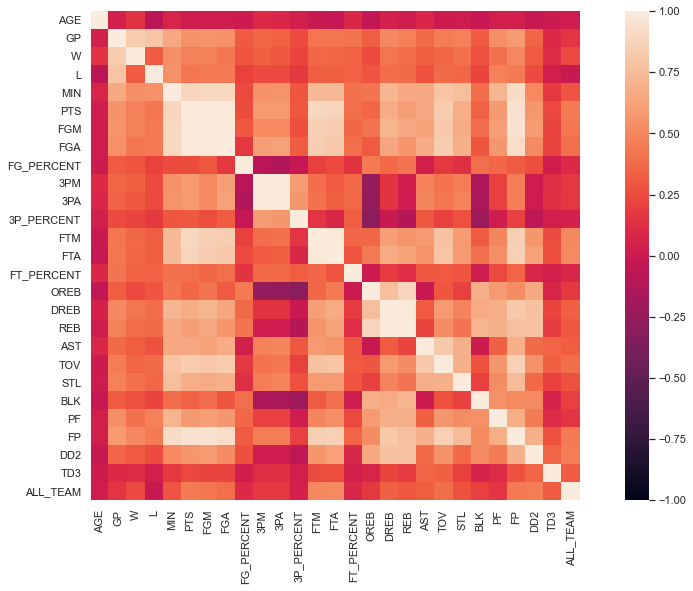

In [8]:
# plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True);

Create Training and Testing Sets

As noted above, the imbalanced dataset has a very small percentage of players selected to the All-NBA Team. Given this situation, it is possible to create training and/or testing sets comprised of a single target variable (e.g. - only 0s or only 1s) since the training and testing sets are choosen at random. Stratified sampling was used to avoid this predicament.

In [9]:
# remove PLAYER, YEAR, TEAM, FG_PERCENT, 3P_PERCENT, and FT_PERCENT from the dataset
data = full_data_set.drop(columns=["PLAYER", "YEAR", "TEAM", "FG_PERCENT", "3P_PERCENT", "FT_PERCENT"])

In [10]:
# create stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], train_size=0.8, stratify=data.ALL_TEAM, random_state=38)

In [11]:
# standardize the training and testing data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [12]:
X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape

((3877, 23), (970, 23), (3877,), (970,))

#### Modeling

We begin modeling with simple logistic regression and then try more complex classifiers. Each model is trained using a 5-fold cross-validated grid search to find the optimal hyperparameters and then tested with a test set that the model has not seen before. An accuracy score, AUC score, confusion matrix, and ROC curve are calculated for each model.

In [13]:
# define a function to plot the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(b=True);

Train a Logistic Regressor using a cross-validated grid search.

In [14]:
# set up a parameter grid for grid search
search_grid = {"penalty": ["l1", "l2", "elasticnet", "none"]}
search_grid

{'penalty': ['l1', 'l2', 'elasticnet', 'none']}

In [15]:
# instantiate a Logistic Regressor
log_reg = LogisticRegression()

# instantiate a GridSearchCV
grid_search = GridSearchCV(log_reg, search_grid,
                           cv=5, n_jobs=6,
                           scoring="roc_auc")

# conduct a grid search
grid_search.fit(X_train_std, y_train)

# view the results of the grid search
grid_search.best_params_

{'penalty': 'l2'}

In [16]:
# get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test_std)

# get the predicted probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test_std)

# isolate the positive probabilities
y_prob = y_prob[:, 1]

# calculate the accuracy score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred).round(4)))

# calculate the AUC score
print("AUC score: {}".format(roc_auc_score(y_test, y_prob).round(4)))

Accuracy: 0.9948
AUC score: 0.9984


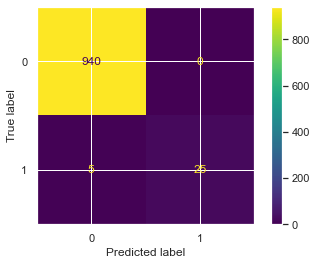

In [17]:
# look at the confusion matrix
plot_confusion_matrix(grid_search.best_estimator_, X_test_std, y_test);

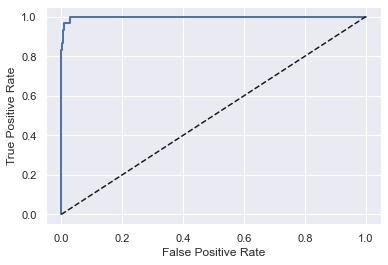

In [18]:
# compute the False Positive Rate (FPR) and the True Positive Rate (TPR) for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the ROC curve
plot_roc_curve(fpr, tpr)

Train a Support Vector Classifier using a cross-validated grid search.

In [19]:
# set up a parameter grid for grid search
search_grid = {"kernel": ["linear", "poly", "rbf", "sigmoid"]}
search_grid

{'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [20]:
# instantiate a Support Vector Classifier
svc_model = SVC(probability=True)

# instantiate a GridSearchCV
grid_search = GridSearchCV(svc_model, search_grid,
                           cv=5, n_jobs=6,
                           scoring="roc_auc")

# conduct a grid search
grid_search.fit(X_train_std, y_train)

# view the results of the grid search
grid_search.best_params_

{'kernel': 'linear'}

In [21]:
# get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test_std)

# get the predicted probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test_std)

# isolate the positive probabilities
y_prob = y_prob[:, 1]

# calculate the accuracy score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred).round(4)))

# calculate the AUC score
print("AUC score: {}".format(roc_auc_score(y_test, y_prob).round(4)))

Accuracy: 0.9938
AUC score: 0.9984


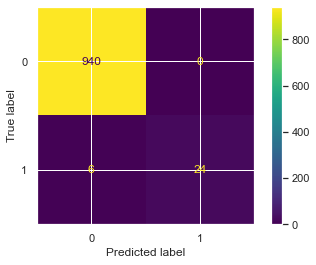

In [22]:
# look at the confusion matrix
plot_confusion_matrix(grid_search.best_estimator_, X_test_std, y_test);

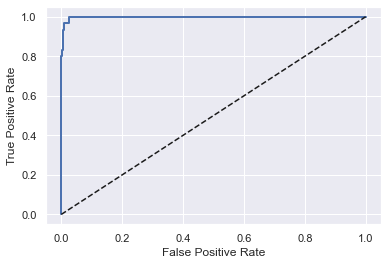

In [23]:
# compute the False Positive Rate (FPR) and the True Positive Rate (TPR) for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the ROC curve
plot_roc_curve(fpr, tpr)

Train a Random Forest Classifier using a cross-validated grid search.

In [24]:
# set up a parameter grid for grid search
search_grid = {"max_depth": [5, 10, 15, None],
               "min_samples_leaf": [1, 2, 3, 4],
               "n_estimators": [200, 400, 600, 800, 1000]}
search_grid

{'max_depth': [5, 10, 15, None],
 'min_samples_leaf': [1, 2, 3, 4],
 'n_estimators': [200, 400, 600, 800, 1000]}

In [25]:
# instantiate a Random Forest Classifier
rfc = RandomForestClassifier()

# instantiate a GridSearchCV
grid_search = GridSearchCV(rfc, search_grid,
                           cv=5, n_jobs=6,
                           scoring="roc_auc")

# conduct a grid search
grid_search.fit(X_train_std, y_train)

# view the results of the grid search
grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 600}

In [26]:
# get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test_std)

# get the predicted probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test_std)

# isolate the positive probabilities
y_prob = y_prob[:, 1]

# calculate the accuracy score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred).round(4)))

# calculate the AUC score
print("AUC score: {}".format(roc_auc_score(y_test, y_prob).round(4)))

Accuracy: 0.9918
AUC score: 0.9968


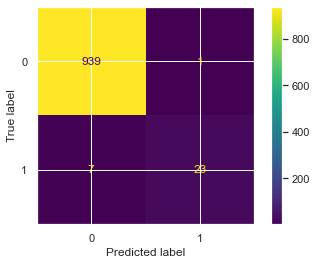

In [27]:
# look at the confusion matrix
plot_confusion_matrix(grid_search.best_estimator_, X_test_std, y_test);

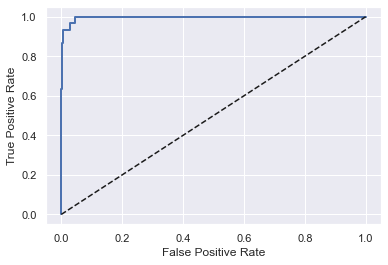

In [28]:
# compute the False Positive Rate (FPR) and the True Positive Rate (TPR) for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the ROC curve
plot_roc_curve(fpr, tpr)

Each classifier tested thus far produces an accuracy and AUC score that is above the 96% threshold we need! However, we may be able to improve the performance of each model by training it on a balanced dataset. Rather than continuing to instantiate, train, and test different models, let's augment the training set using oversampling.

Data Augmentation

Oversampling is used to augment imbalanced training sets by generating fictional training data using the distribution of each feature in the minority sample. We implement oversampling using these 5 steps.  
1. Isolate the minority observations
2. Get the mean of each feature
3. Get the standard deviation of each feature
4. Generate fictional data with a random distribution using the mean and standard deviation found for each feature
5. Add the fictional data to the dataset  

By adding an equal number of fictional observations to the original dataset, we can create a balanced dataset that may improve training and testing of the model.

In [29]:
# isolate the observations where ALL_TEAM == 1 and drop the ALL_TEAM column
all_team_data = data[data.ALL_TEAM == 1].iloc[:, :-1]

In [30]:
# get the mean and standard deviation for each feature of the all_team_data
mean = all_team_data.mean()
std = all_team_data.std()

In [31]:
# set the seed of the random number generator for reproducibility
rng = np.random.default_rng(38)

# generate a normally distributed set of data using the mean and std calculated above
generated_data = rng.normal(mean, std, size=(4547, 23))

In [32]:
# put the generated data in a dataframe
gd_df = pd.DataFrame(generated_data, columns=all_team_data.columns)

# add an ALL_TEAM column to the generated data
gd_df["ALL_TEAM"] = 1

# set dtypes for the generated data to match the original data dtypes
gd_df.AGE = gd_df.AGE.astype(np.int64)
gd_df.GP = gd_df.GP.astype(np.int64)
gd_df.W = gd_df.W.astype(np.int64)
gd_df.L = gd_df.L.astype(np.int64)
gd_df.DD2 = gd_df.DD2.astype(np.int64)
gd_df.TD3 = gd_df.TD3.astype(np.int64)

In [33]:
# concatenate the original data with the generated data
augmented_data = pd.concat([data, gd_df])

# shuffle the augmented data into the original data
augmented_data = augmented_data.sample(n=augmented_data.shape[0]).reset_index(drop=True)

# take a look at the augmented dataframe
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9394 entries, 0 to 9393
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AGE       9394 non-null   int64  
 1   GP        9394 non-null   int64  
 2   W         9394 non-null   int64  
 3   L         9394 non-null   int64  
 4   MIN       9394 non-null   float64
 5   PTS       9394 non-null   float64
 6   FGM       9394 non-null   float64
 7   FGA       9394 non-null   float64
 8   3PM       9394 non-null   float64
 9   3PA       9394 non-null   float64
 10  FTM       9394 non-null   float64
 11  FTA       9394 non-null   float64
 12  OREB      9394 non-null   float64
 13  DREB      9394 non-null   float64
 14  REB       9394 non-null   float64
 15  AST       9394 non-null   float64
 16  TOV       9394 non-null   float64
 17  STL       9394 non-null   float64
 18  BLK       9394 non-null   float64
 19  PF        9394 non-null   float64
 20  FP        9394 non-null   floa

We now have 9,394 observations in the dataset where half of the observations are labelled ALL_TEAM = 1, a perfectly balanced dataset with twice the number of observations than the original dataset.

Create a Training Set with the Augmented Data

Although we want to use the augmented dataset for training, we still want to test the model with the original test set. Hence, underscores are used to catch the unneeded results returned by train_test_split() below.

In [34]:
# create an augmented training set
X_train_aug, _, y_train_aug, _ = train_test_split(augmented_data.iloc[:, :-1], augmented_data.iloc[:, -1], train_size=0.8, random_state=38)

*Note: standardize the original test set using the mean and standard deviation of the augmented training set.*

In [35]:
# standardize the augmented training data
aug_scaler = StandardScaler()
X_train_aug_std = aug_scaler.fit_transform(X_train_aug)

# standardize the original test data using the mean and std from the augmented scaler
X_test_aug_std = aug_scaler.transform(X_test)

In [36]:
X_train_aug_std.shape, X_test_aug_std.shape, y_train_aug.shape, y_test.shape

((7515, 23), (970, 23), (7515,), (970,))

Train a Voting Classifier

Instead of repeating the instantiation, cross-validated grid search training, and testing of each individual model like  was done above, let's create an ensemble model with default versions of the same three classifiers to see if we can produce better results without having to spend time optimizing each model.

In [37]:
# instantiate the individual classifiers with their default hyperparameters
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

In [38]:
# instantiate a Voting Classifier
voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
                              voting="soft",
                              n_jobs=6)

In [39]:
# calculate the accuracy and AUC score for each model
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train_aug_std, y_train_aug)
    y_pred = clf.predict(X_test_aug_std)
    y_prob = clf.predict_proba(X_test_aug_std)[:, 1]
    print("Accuracy: {} {}".format(clf.__class__.__name__, accuracy_score(y_test, y_pred).round(4)))
    print("AUC score: {} {}".format(clf.__class__.__name__, roc_auc_score(y_test, y_prob).round(4)))
    print()

Accuracy: LogisticRegression 0.9876
AUC score: LogisticRegression 0.9985

Accuracy: RandomForestClassifier 0.9979
AUC score: RandomForestClassifier 0.9996

Accuracy: SVC 0.9928
AUC score: SVC 0.9976

Accuracy: VotingClassifier 0.9928
AUC score: VotingClassifier 0.9993



The Random Forest Classifier with default hyperparameters had both the highest accuracy score and the highest AUC score. Therefore, the Random Forest Classifier is selected as the final model. Looking at the confusion matrix, we see that the final model only produced two false positives!

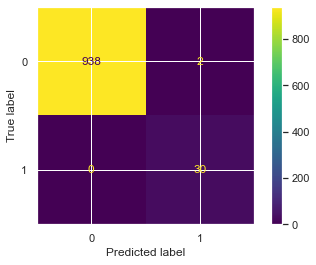

In [40]:
# look at the confusion matrix
plot_confusion_matrix(rnd_clf, X_test_aug_std, y_test);

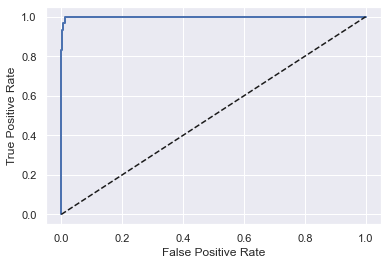

In [41]:
# compute the False Positive Rate (FPR) and the True Positive Rate (TPR) for various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the ROC curve
plot_roc_curve(fpr, tpr)

#### Conclusion

Based on the results of this study, it seems feasible that a classification model can be used to predict the probability an NBA player is selected for the All-NBA Team. The final Random Forest Classifier acheived an accuracy score of 99.79%, which is greater than the 96% threshold established by the naïve model. The AUC score of 0.9996 and the resulting confusion matrix add confidence that the model is able to successfully distinguish between both classes of labels. Even though the initial models produced both accuracy and AUC scores that were above 99%, building and training the models with default hyperparameters using an augmented dataset improved their respective accuracy and AUC scores in each case. Future researchers may want to expand on this study by trying to predict which All-NBA Team - first, second, or third string - a player is selected.

---

##### Glossary

AGE - Age  
GP - Games Played  
W - Wins  
L - Losses  
MIN - Minutes Played  
PTS - Points 
FGM - Field Goals Made  
FGA - Field Goals Attempted  
FG% - Field Goal Percentage  
3PM - 3 Point Field Goals Made  
3PA - 3 Point Field Goals Attempted  
3P% - 3 Point Field Goals Percentage  
FTM - Free Throws Made  
FTA - Free Throws Attempted  
FT% - Free Throw Percentage  
OREB - Offensive Rebounds  
DREB - Defensive Rebounds  
REB - Rebounds  
AST - Assists  
TOV - Turnovers  
STL - Steals  
BLK - Blocks  
PF - Personal Fouls  
FP - Fantasy Points  
DD2 - Double doubles  
TD3 - Triple doubles   
ALL_TEAM - Selected to All-NBA Team